In [1]:
# standard numerical library imports
import numpy as np

# energyflow imports
import energyflow as ef
from energyflow.archs import EFN
from energyflow.datasets import qg_jets
from energyflow.utils import data_split, to_categorical

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

#!pip install github.com/rikab/rikabplotlib.git
from rikabplotlib.plot_utils import newplot, hist_with_outline, hist_with_errors

2024-09-13 00:05:27.422670: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/ot/backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())


In [34]:
N_jets = 25000
R = 0.4
X, y = qg_jets.load(N_jets)

# Jet only jets with y = 1
X = X[y == 1][:N_jets]

# Preprocess
X = X[:,:,:3]
total_energy = np.sum(X[:,:,0], axis=1)
for x in X:
    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

def compute_angularity(X, beta = 1):
    return np.sum(X[:,:,0] * np.power((X[:,:,1]**2 + X[:,:,2]**2),(beta/2)) / np.power(R, beta) , axis=1)




In [44]:
def alpha_s(scale):
    lambda_qcd = 0.2
    beta_0 = 11 - 2/3 * 3
    return 4 * np.pi / (beta_0 * np.log(scale**2 / lambda_qcd**2))

def LO_angularity(lambda_, beta = 1):

    scale = 500 * np.power(lambda_, 1 / (beta))

    alpha_s_scale = alpha_s(scale)
    C_F = 4/3
    C_A = 3

    return -(2 * alpha_s_scale * C_F / (1 * np.pi * beta * R)) * np.log(lambda_ ) / lambda_

def LL_angularity(lambda_, beta = 1):

    scale = 500 * np.power(lambda_, 1 / (beta))

    alpha_s_scale = alpha_s(scale)
    C_F = 4/3
    C_A = 3

    return LO_angularity(lambda_, beta) * np.exp(- 1 * alpha_s_scale * C_F / (beta * R *  np.pi) * np.power(np.log(lambda_), 2))

# # plot alpha_s as a function of scale
# lambdas = np.logspace(0, 2, 100)
# alphas = np.array([alpha_s(l) for l in lambdas])
# plt.plot(lambdas, alphas)


3.713611478355496
[3.21919183e+00 8.16664840e+00 9.72796984e+00 9.78084463e+00
 9.28190307e+00 8.60808832e+00 7.90847322e+00 7.24141151e+00
 6.62763172e+00 6.07188899e+00 5.57223476e+00 5.12412194e+00
 4.72224803e+00 4.36137085e+00 4.03664637e+00 3.74374279e+00
 3.47885144e+00 3.23865272e+00 3.02026505e+00 2.82119054e+00
 2.63926319e+00 2.47260225e+00 2.31957142e+00 2.17874362e+00
 2.04887103e+00 1.92885950e+00 1.81774702e+00 1.71468530e+00
 1.61892432e+00 1.52979910e+00 1.44671850e+00 1.36915566e+00
 1.29663985e+00 1.22874944e+00 1.16510593e+00 1.10536874e+00
 1.04923076e+00 9.96414478e-01 9.46668612e-01 8.99765197e-01
 8.55497025e-01 8.13675421e-01 7.74128277e-01 7.36698341e-01
 7.01241695e-01 6.67626422e-01 6.35731419e-01 6.05445351e-01
 5.76665715e-01 5.49298015e-01 5.23255017e-01 4.98456092e-01
 4.74826619e-01 4.52297460e-01 4.30804479e-01 4.10288115e-01
 3.90692995e-01 3.71967584e-01 3.54063872e-01 3.36937088e-01
 3.20545437e-01 3.04849873e-01 2.89813879e-01 2.75403274e-01
 2.615

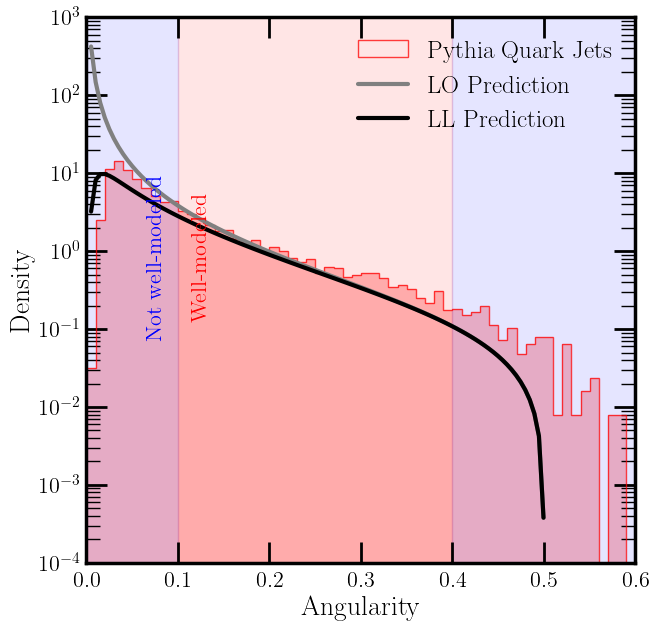

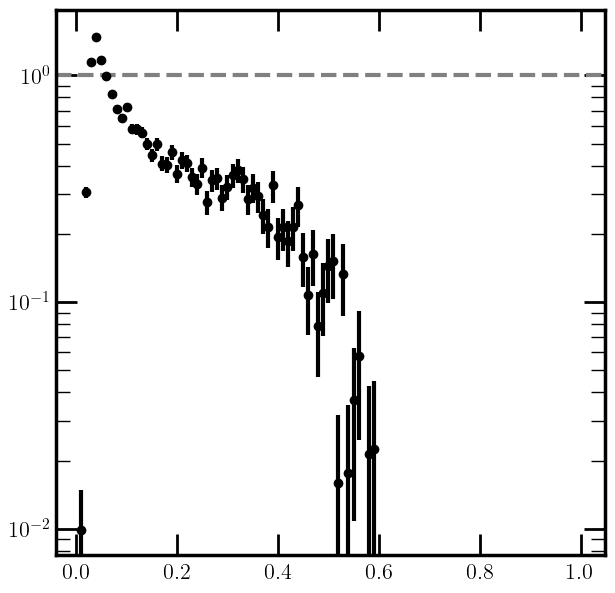

In [45]:
beta = 1

fig, ax = newplot("full")

normalized_angularity = compute_angularity(X, beta=beta) 
# normalized_angularity = normalized_angularity / np.max(normalized_angularity)
np.save("normalized_angularity.npy", normalized_angularity)
bins, edges = np.histogram(normalized_angularity, bins=100, range=(0,1))

errors = np.sqrt(bins)
total_norm = np.sum(bins) * (edges[1] - edges[0])
bins = bins / total_norm
errors = errors / total_norm 



hist_with_outline(ax, normalized_angularity, bins=100, range=(0,1),  density = True, color = "red", label = "Pythia Quark Jets")
lambdas = np.linspace(0.01, 0.999, 100)

densities = LO_angularity(lambdas, beta = beta)
densities = np.maximum(0, densities)
# normalize angularities so the integral is 1
print(np.trapz(densities, lambdas))
# densities = densities / np.trapz(densities, lambdas) 
ax.plot(lambdas / 2, densities * 2, color="grey", label = "LO Prediction")

densities = LL_angularity(lambdas, beta = beta)
densities *= 2
print(densities)
ax.plot(lambdas / 2, densities, color="black", label = "LL Prediction")

# print the integral of densities
print(np.trapz(LL_angularity(np.linspace(0.001, 1, 10000), beta = beta), np.linspace(0.001, 1, 10000)))


plt.xlabel("Angularity")
plt.ylabel("Density")
plt.yscale("log")


# add verticle line at 0.8
plt.axvline(0.9, color="grey", linestyle="--")

# to the left of 0.8, fill in the area
ax.fill_betweenx([0, 1e3], 0, 0.1, color="blue", alpha=0.1)
ax.fill_betweenx([0, 1e3], 0.4, 0.6, color="blue", alpha=0.1)
plt.text(0.075, 0.8, "Not well-modeled", color="blue", rotation=90, va="center", ha="center")

# to the right of 0.8, fill in the area
ax.fill_betweenx([0, 1e3], 0.1, 0.4, color="red", alpha=0.1)
plt.text(0.125, 0.8, "Well-modeled", color="red", rotation=90, va="center", ha="center")


plt.ylim(1e-4, 1e3)
plt.xlim(0, 0.6)
plt.legend(frameon=False, loc="upper right")

plt.savefig("angularity_prediction.pdf", bbox_inches="tight")

fig, ax = newplot("full")

# ratio
print(lambdas.shape, densities.shape, normalized_angularity.shape)

plt.errorbar(lambdas, bins / densities , yerr = errors / densities, label="Ratio", color="black", fmt="o")

# line at 1
plt.axhline(1, color="grey", linestyle="--")
plt.yscale("log")
